In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/breast-cancer-wisconsin-data/data.csv


In [2]:
# Python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from itertools import chain
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

warnings.filterwarnings('ignore') #ignore warning messages 

In [3]:
# Read data
data = pd.read_csv('../input/breast-cancer-wisconsin-data/data.csv')
data.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

In [4]:
#Missing values
null_feat = pd.DataFrame(len(data['id']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'lightgrey',
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  "Missing Values")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [5]:
# Drop useless variables
data = data.drop(['Unnamed: 32','id'],axis = 1)

# Reassign target
data.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

In [6]:
#Exploratory Data Analysis (EDA)
# Head
data.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          17.33           184.60   
1         0.1812  ...         24.99          23.41           158.80   
2         0.2069  ...         23.57          25.53           152.50   
3         0.2597  ...         14.91          26.50            98.87   
4         0.1809  ...         22.54          16.67           152.20   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 31 columns]

In [7]:
# Describe
data.describe()

diagnosis  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  569.000000   569.000000    569.000000      569.000000   569.000000   
mean     0.372583    14.127292     19.289649       91.969033   654.889104   
std      0.483918     3.524049      4.301036       24.298981   351.914129   
min      0.000000     6.981000      9.710000       43.790000   143.500000   
25%      0.000000    11.700000     16.170000       75.170000   420.300000   
50%      0.000000    13.370000     18.840000       86.240000   551.100000   
75%      1.000000    15.780000     21.800000      104.100000   782.700000   
max      1.000000    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
count     569.000000  ...    569.000000     569.000000       569.000000   
mean        0.181162  ...     16.269190      25.677223       107.261213   
std         0.027414  ...      4.833242       6.146258        33.602542   
min         0.106000  ...      7.930000      12.020000        50.410000   
25%         0.161900  ...     13.010000      21.080000        84.110000   
50%         0.179200  ...     14.970000      25.410000        97.660000   
75%         0.195700  ...     18.790000      29.720000       125.400000   
max         0.304000  ...     36.040000      49.540000       251.200000   

        area_worst  smoothness_worst  compactness_worst  concavity_worst  \
count   569.000000        569.000000         569.000000       569.000000   
mean    880.583128          0.132369           0.254265         0.272188   
std     569.356993          0.022832           0.157336         0.208624   
min     185.200000          0.071170           0.027290         0.000000   
25%     515.300000          0.116600           0.147200         0.114500   
50%     686.500000          0.131300           0.211900         0.226700   
75%    1084.000000          0.146000           0.339100         0.382900   
max    4254.000000          0.222600           1.058000         1.252000   

       concave points_worst  symmetry_worst  fractal_dimension_worst  
count            569.000000      569.000000               569.000000  
mean               0.114606        0.290076                 0.083946  
std                0.065732        0.061867                 0.018061  
min                0.000000        0.156500                 0.055040  
25%                0.064930        0.250400                 0.071460  
50%                0.099930        0.282200                 0.080040  
75%                0.161400        0.317900                 0.092080  
max                0.291000        0.663800                 0.207500  

[8 rows x 31 columns]

In [8]:
#Target distribution (number and %)
# 2 datasets
M = data[(data['diagnosis'] != 0)]
B = data[(data['diagnosis'] == 0)]

In [9]:
#------------COUNT-----------------------
trace = go.Bar(x = (len(M), len(B)), y = ['malignant', 'benign'], orientation = 'h', opacity = 0.8, marker=dict(
        color=[ 'gold', 'lightskyblue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of diagnosis variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

#------------PERCENTAGE-------------------
trace = go.Pie(labels = ['benign','malignant'], values = data['diagnosis'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue', 'gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of diagnosis variable')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

**Features distribution(hue = diagnosis)**

In [10]:
def plot_distribution(data_select, size_bin) :  
    tmp1 = M[data_select]
    tmp2 = B[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['malignant', 'benign']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')

In [11]:
#plot distribution 'mean'
plot_distribution('radius_mean',.5)
plot_distribution('texture_mean',.5)
plot_distribution('perimeter_mean',5)
plot_distribution('area_mean',10)
plot_distribution('smoothness_mean',.5)
plot_distribution('compactness_mean',.5)
plot_distribution('concavity_mean',.5)
plot_distribution('concave points_mean',.5)
plot_distribution('symmetry_mean', .5)
plot_distribution('fractal_dimension_mean',.5)

In [12]:
#plot distribution 'se'
plot_distribution('radius_se', .1)
plot_distribution('texture_se', .1)
plot_distribution('perimeter_se', .5)
plot_distribution('area_se', 5)
plot_distribution('smoothness_se', .5)
plot_distribution('compactness_se', .5)
plot_distribution('concavity_se', .5)
plot_distribution('concave points_se', .5)
plot_distribution('symmetry_se', .5)
plot_distribution('fractal_dimension_se', .5)

In [13]:
#correlation
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   xgap = 2,
                   ygap = 2,
                   colorscale='Viridis',
                   colorbar   = dict() ,
                  )
layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                     ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9)),
                       )
                  )
fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)

In [14]:
#Positive correlated features
def plot_feat1_feat2(feat1, feat2) :  
    trace0 = go.Scatter(
        x = M[feat1],
        y = M[feat2],
        name = 'malignant',
        mode = 'markers', 
        marker = dict(color = '#FFD700',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = B[feat1],
        y = B[feat2],
        name = 'benign',
        mode = 'markers',
        marker = dict(color = '#7EC0EE',
            line = dict(
                width = 1)))

    layout = dict(title = feat1 +" "+"vs"+" "+ feat2,
                  yaxis = dict(title = feat2,zeroline = False),
                  xaxis = dict(title = feat1, zeroline = False)
                 )

    plots = [trace0, trace1]

    fig = dict(data = plots, layout=layout)
    py.iplot(fig)

In [15]:
plot_feat1_feat2('perimeter_mean','radius_worst')
plot_feat1_feat2('area_mean','radius_worst')
plot_feat1_feat2('texture_mean','texture_worst')
plot_feat1_feat2('area_worst','radius_worst')

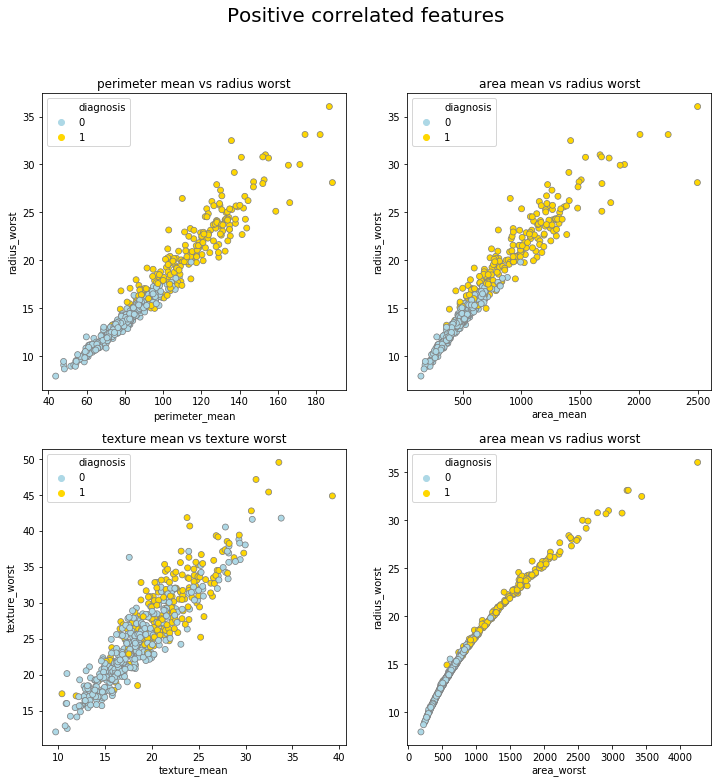

In [16]:
#seaborn version : 

palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'grey'

# Plot +
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['perimeter_mean'], y = data['radius_worst'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor=edgecolor)
plt.title('perimeter mean vs radius worst')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['area_mean'], y = data['radius_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('area mean vs radius worst')
plt.subplot(223)
ax3 = sns.scatterplot(x = data['texture_mean'], y = data['texture_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('texture mean vs texture worst')
plt.subplot(224)
ax4 = sns.scatterplot(x = data['area_worst'], y = data['radius_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('area mean vs radius worst')

fig.suptitle('Positive correlated features', fontsize = 20)
plt.savefig('1')
plt.show()

In [17]:
#Uncorrelated features
plot_feat1_feat2('smoothness_mean','texture_mean')
plot_feat1_feat2('radius_mean','fractal_dimension_worst')
plot_feat1_feat2('texture_mean','symmetry_mean')
plot_feat1_feat2('texture_mean','symmetry_se')

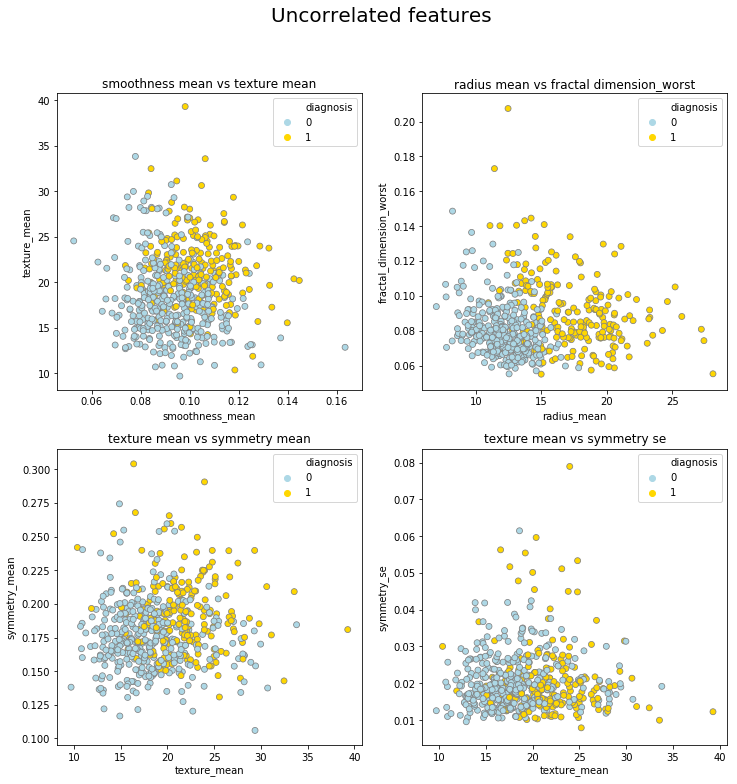

In [18]:
# seaborn version : 
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['smoothness_mean'], y = data['texture_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('smoothness mean vs texture mean')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['radius_mean'], y = data['fractal_dimension_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('radius mean vs fractal dimension_worst')
plt.subplot(223)
ax3 = sns.scatterplot(x = data['texture_mean'], y = data['symmetry_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('texture mean vs symmetry mean')
plt.subplot(224)
ax4 = sns.scatterplot(x = data['texture_mean'], y = data['symmetry_se'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('texture mean vs symmetry se')

fig.suptitle('Uncorrelated features', fontsize = 20)
plt.savefig('2')
plt.show()

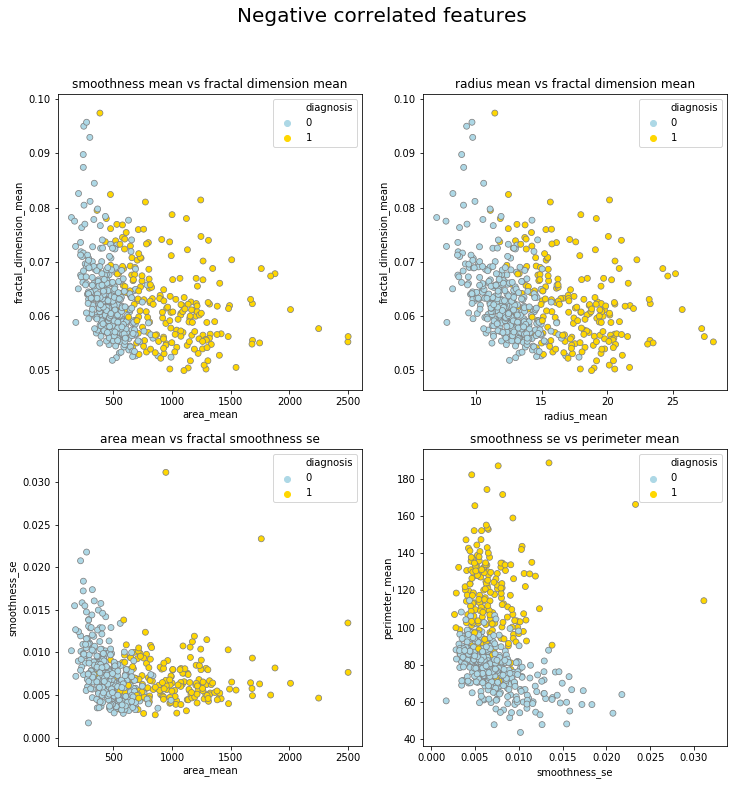

In [19]:
# seaborn version
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['area_mean'], y = data['fractal_dimension_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('smoothness mean vs fractal dimension mean')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['radius_mean'], y = data['fractal_dimension_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('radius mean vs fractal dimension mean')
plt.subplot(223)
ax2 = sns.scatterplot(x = data['area_mean'], y = data['smoothness_se'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('area mean vs fractal smoothness se')
plt.subplot(224)
ax2 = sns.scatterplot(x = data['smoothness_se'], y = data['perimeter_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('smoothness se vs perimeter mean')

fig.suptitle('Negative correlated features', fontsize = 20)
plt.savefig('3')
plt.show()

****Principal Component Analysis****

In [20]:
#Compute PCA

target_pca = data['diagnosis']
data_pca = data.drop('diagnosis', axis=1)

target_pca = pd.DataFrame(target_pca)

#To make a PCA, normalize data is essential
X_pca = data_pca.values
X_std = StandardScaler().fit_transform(X_pca)

pca = PCA(svd_solver='full')
pca_std = pca.fit(X_std, target_pca).transform(X_std)

pca_std = pd.DataFrame(pca_std)
pca_std = pca_std.merge(target_pca, left_index = True, right_index = True, how = 'left')
pca_std['diagnosis'] = pca_std['diagnosis'].replace({1:'malignant',0:'benign'})

In [21]:
#PCA pie plot with 6 components (88.8%)

#explained_variance 
var_pca = pd.DataFrame(pca.explained_variance_ratio_)
var_pca = var_pca.T

#----------SUM AND DROP COMP [7:30]
col_list = list(v for v in chain(pca_std.columns[6:30])) 
var_pca['OTHERS_COMP'] = var_pca[col_list].sum(axis=1)
var_pca.drop(var_pca[col_list],axis=1,inplace=True)
var_pca = var_pca.T

In [22]:
labels = ['COMP1','COMP2','COMP3','COMP4','COMP5','COMP6', 'COMP7 - 30']
colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightgrey', 'orange', 'white']

trace = go.Pie(labels = labels, values = var_pca[0].values, opacity = 0.8,
               textfont=dict(size=15),
               marker=dict(colors=colors, 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'PCA : components and explained variance (6 comp = 88.8%)')
 
                   
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [23]:
#PCA scatter plot with 2 components (63.3%)
pca = PCA(n_components = 2)

pca_std = pca.fit(X_std, target_pca).transform(X_std)
pca_std = pd.DataFrame(pca_std,columns = ['COMP1','COMP2'])
pca_std = pca_std.merge(target_pca,left_index = True,right_index = True,how = 'left')
pca_std['diagnosis'] = pca_std['diagnosis'].replace({1:'malignant',0:'benign'})

In [24]:
def pca_scatter(target,color) :
    tracer = go.Scatter(x = pca_std[pca_std['diagnosis'] == target]['COMP1'] ,
                        y = pca_std[pca_std['diagnosis'] == target]['COMP2'],
                        name = target, mode = 'markers',
                        marker = dict(color = color,line = dict(width = 1))
                       )
    return tracer
layout = go.Layout(dict(title = 'PCA Scatter plot (2 comp = 63.3%)',
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = 'COMP1 = 44.3%',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = 'COMP2 = 19.0%',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        height = 800
                       ))
trace1 = pca_scatter('malignant','#FFD700')
trace2 = pca_scatter('benign','#7EC0EE')
plots = [trace2,trace1]
fig = go.Figure(data = plots,layout = layout)
py.iplot(fig)

In [25]:
#PCA scatter plot with 3 components (72.7%)
pca = PCA(n_components = 3)
pca_std = pca.fit(X_std, target_pca).transform(X_std)

pca_std = pd.DataFrame(pca_std,columns = ['COMP1','COMP2','COMP3'])
pca_std = pca_std.merge(target_pca, left_index = True, right_index = True,how = 'left')
pca_std['diagnosis'] = pca_std['diagnosis'].replace({1:'malignant',0:'benign'})
M_pca = pca_std[(pca_std['diagnosis'] == 'malignant')]
B_pca = pca_std[(pca_std['diagnosis'] == 'benign')]
trace1 = go.Scatter3d(x = M_pca['COMP1'],
                      y = M_pca['COMP3'],
                      z = M_pca['COMP2'],
                      mode = "markers",
                      name = "malignant",
                      marker = dict(size = 4,color = '#FFD700',line = dict(width = 1))
                     )
trace2 = go.Scatter3d(x = B_pca['COMP1'],
                      y = B_pca['COMP3'],
                      z = B_pca['COMP2'],
                      name = 'benign',
                      mode = 'markers',
                      marker = dict(size = 4,color= '#7EC0EE',line = dict(width = 1))
                     )



layout = go.Layout(dict(title = 'PCA Scatter plot (3 comp = 72.7%)',
                        scene = dict(camera = dict(up=dict(x= 0 , y=0, z=0),
                                                   center=dict(x=0, y=0, z=0),
                                                   eye=dict(x=1.25, y=1.25, z=1.25)),
                                     xaxis  = dict(title = 'COMP1',
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'),
                                     yaxis  = dict(title = 'COMP3',
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'
                                                  ),
                                     zaxis  = dict(title = 'COMP2',
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'
                                                  )),height = 700))
                  

plots = [trace1,trace2]
fig  = go.Figure(data = plots,layout = layout)
py.iplot(fig)

**Confusion matrix and show metrics**

**The confusion matrix, also known as the error matrix, allows visualization of the performance of an algorithm :**

true positive (TP) : Malignant tumour correctly identified as malignant
true negative (TN) : Benign tumour correctly identified as benign
false positive (FP) : Benign tumour incorrectly identified as malignant
false negative (FN) : Malignant tumour incorrectly identified as benign

**Metrics :**
Accuracy : (TP +TN) / (TP + TN + FP +FN)

Precision : TP / (TP + FP)

Recall : TP / (TP + FN)

In [26]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Show metrics 
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

In [27]:
# Precision-recall curve
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

In [28]:
# ROC curve
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
   # plt.xlim([0.0,0.001])
   # plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

In [29]:
# Learning curve
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    return plt

**Cross validation metrics**

Cross-validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it.

In [30]:
# Cross val metric
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

**PREPARE DATASET**

**Define (X, y)**

y = diagnosis (target)
X = features (radius_mean, area_se, ....)

In [31]:
# Def X and Y
y = np.array(data.diagnosis.tolist())
data = data.drop('diagnosis', 1)
X = np.array(data.as_matrix())

**Standard scaler(X)**

Why do you need to standardize your data ? For example, a variable that ranges between 0 and 100 will outweigh a variable that ranges between 0 and 1. 
Using these variables without standardization in effect gives the variable with the larger range a bigger weight in the analysis

In [32]:
# Normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train_test split
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.12, random_state = random_state)

**Predictive model : Logistic Regression**

In [33]:
#1.Logistic Regression and GridSearch CV to optimise hyperparameters (accuracy)
# Find best hyperparameters (accuracy)
log_clf = LogisticRegression(random_state = random_state)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

CV_log_clf = GridSearchCV(estimator = log_clf, param_grid = param_grid , scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_log_clf.fit(X_train, y_train)

best_parameters = CV_log_clf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


The best parameters for using this model is {'C': 0.1, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    2.3s finished


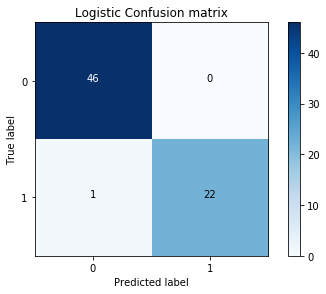

Accuracy  =     0.986
Precision =     1.000
Recall    =     0.957
F1_score  =     0.978


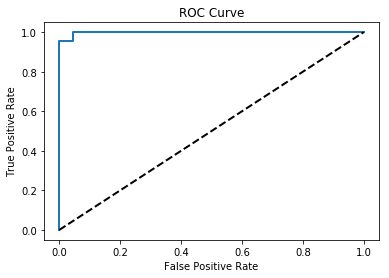

In [34]:
#Log with best hyperparameters
CV_log_clf = LogisticRegression(C = best_parameters['C'], 
                                penalty = best_parameters['penalty'], 
                                random_state = random_state)

CV_log_clf.fit(X_train, y_train)
y_pred = CV_log_clf.predict(X_test)
y_score = CV_log_clf.decision_function(X_test)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

**RFE : Recursive features elimination (30 features => 15 features)**

Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) 
until the specified number of features is reached. 
Features are ranked by the model’s coef_ or featureimportances

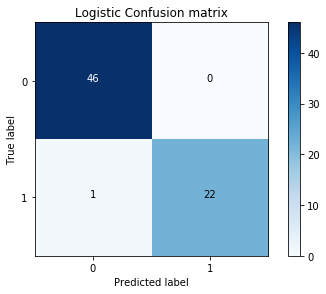

Accuracy  =     0.986
Precision =     1.000
Recall    =     0.957
F1_score  =     0.978


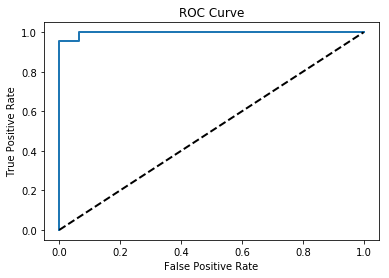

In [35]:
#Logistic regression with RFE
log_clf = LogisticRegression(C = best_parameters['C'], 
                                 penalty = best_parameters['penalty'], 
                                 random_state = random_state)

selector = RFE(log_clf)
selector = selector.fit(X_train, y_train)

y_pred = selector.predict(X_test)
y_score = selector.predict_proba(X_test)[:,1]


# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

In [36]:
# support and ranking RFE
print(selector.support_)
print(selector.ranking_)

[ True  True  True  True False False False  True False False  True False
 False  True False False False False False False  True  True  True  True
  True False  True  True  True False]
[ 1  1  1  1  8 15  4  1 12  7  1 16  2  1 10  5 14 13  9  3  1  1  1  1
  1  6  1  1  1 11]


**Compare learning curves and cross-validation scores**

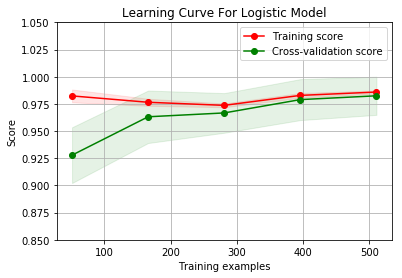

In [37]:
#Learning curve Log with best hyperpara
plot_learning_curve(CV_log_clf, 'Learning Curve For Logistic Model', X, y, (0.85,1.05), 10)
plt.savefig('7')
plt.show()

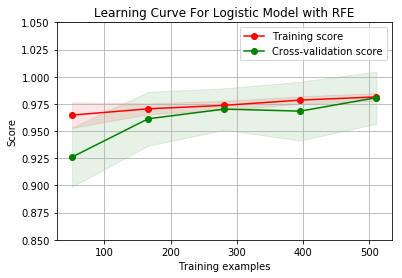

In [38]:
#Learning curve Log with RFE
plot_learning_curve(selector, 'Learning Curve For Logistic Model with RFE', X, y, (0.85,1.05), 10)
plt.show()

In [39]:
# Cross val Log 
cross_log = cross_val_metrics(CV_log_clf)

[accuracy] : 0.98242 (+/- 0.00560)
[precision] : 0.99036 (+/- 0.01181)
[recall] : 0.96235 (+/- 0.01131)


In [40]:
# Cross val Log with RFE
cross_selector = cross_val_metrics(selector)

[accuracy] : 0.97367 (+/- 0.00778)
[precision] : 0.98094 (+/- 0.01754)
[recall] : 0.94817 (+/- 0.01753)


**Select threshold for a recall = 100%(all malignant tumors detected)**

Recall w/ threshold = 0.1 : 1.0
Recall w/ threshold = 0.2 : 0.9565217391304348
Recall w/ threshold = 0.3 : 0.9565217391304348
Recall w/ threshold = 0.4 : 0.9565217391304348
Recall w/ threshold = 0.5 : 0.9565217391304348
Recall w/ threshold = 0.6 : 0.9565217391304348
Recall w/ threshold = 0.7 : 0.9565217391304348
Recall w/ threshold = 0.8 : 0.8695652173913043
Recall w/ threshold = 0.9 : 0.782608695652174


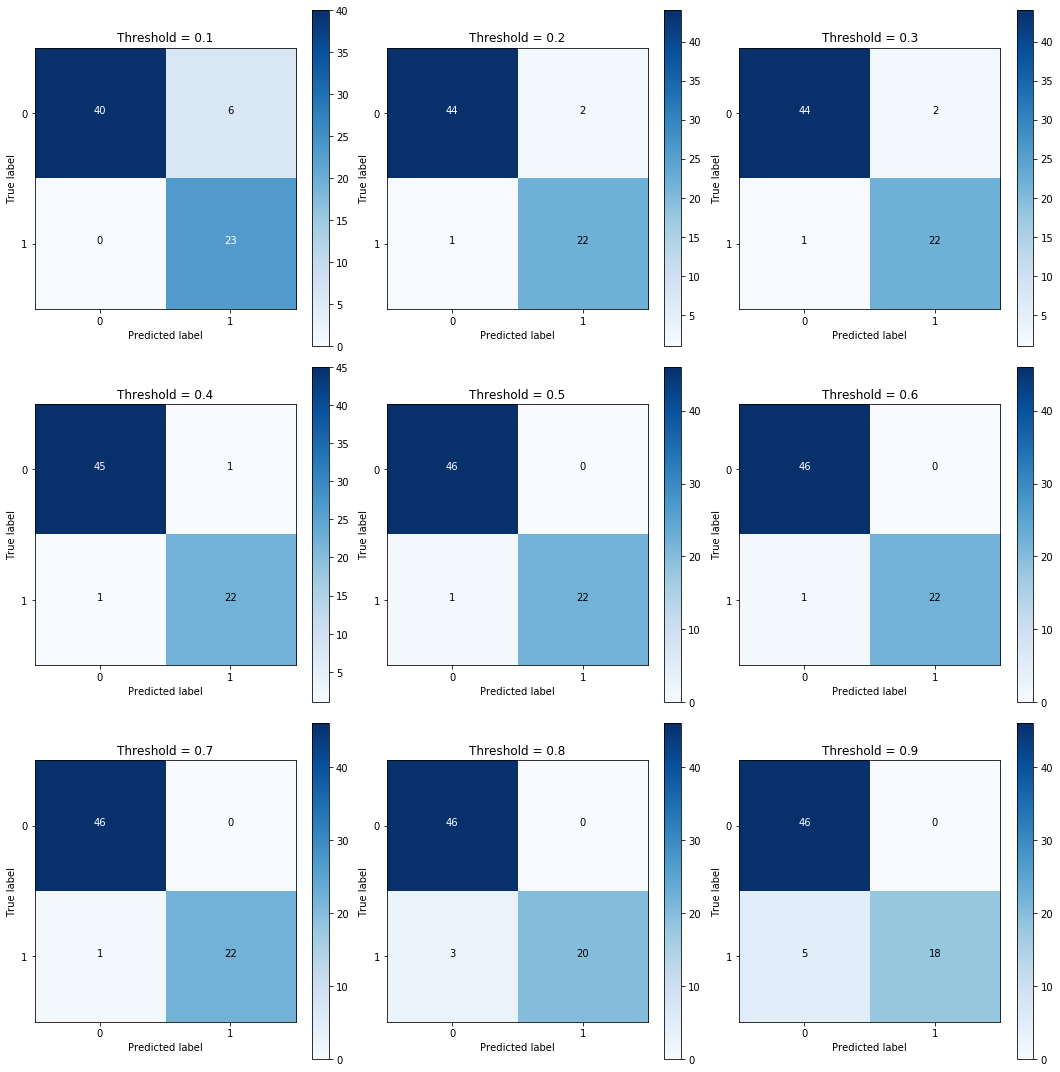

In [41]:
# Threshold
thresholds_adj = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize = (15,15))

j = 1
for i in thresholds_adj:
    y_score = CV_log_clf.predict_proba(X_test)[:,1] > i
    
    
    plt.subplot(3,3,j)
    j += 1
    
    cm = confusion_matrix(y_test, y_score)
    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]

    print('Recall w/ threshold = %s :'%i, (tp/(tp+fn)))
    
    class_names = [0,1]
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='Threshold = %s'%i) 

**Predicting with recall = 100%**

In [42]:
# Recall = 1.
y_score = CV_log_clf.predict_proba(X_test)[:,1] > 0.1
cm = confusion_matrix(y_test, y_score)
class_names = [0,1]
show_metrics()

Accuracy  =     0.913
Precision =     0.793
Recall    =     1.000
F1_score  =     0.885


**Predictive Model-2: Ensemble Classifier to maximise precision and detect all malignant tumors**

In [43]:
#Logistic Regression and GridSearch CV to optimise hyperparameters (recall)

# Find the best parameters (recall)
log2_clf = LogisticRegression(random_state = random_state)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            }

CV_log2_clf = GridSearchCV(estimator = log2_clf, param_grid = param_grid , scoring = 'recall', verbose = 1, n_jobs = -1)
CV_log2_clf.fit(X_train, y_train)

best_parameters = CV_log2_clf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


The best parameters for using this model is {'C': 0.1, 'penalty': 'l1'}


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.5s finished


In [44]:
# Log w best hyperparameters (recall)
CV_log2_clf = LogisticRegression(C = best_parameters['C'], 
                                 penalty = best_parameters['penalty'], 
                                 random_state = random_state)


CV_log2_clf.fit(X_train, y_train)

y_pred = CV_log2_clf.predict(X_test)
y_score = CV_log2_clf.decision_function(X_test)
# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]

In [45]:
# Cross val log2
cross_val_metrics(CV_log2_clf)

[accuracy] : 0.97370 (+/- 0.01556)
[precision] : 0.97628 (+/- 0.02548)
[recall] : 0.95293 (+/- 0.02093)


In [46]:
#Voting Classifier : log + log2
voting_clf = VotingClassifier (
        estimators = [('log1', CV_log_clf), ('log_2', CV_log2_clf)],
                     voting='soft', weights = [1, 1])
    
voting_clf.fit(X_train,y_train)

y_pred = voting_clf.predict(X_test)
y_score = voting_clf.predict_proba(X_test)[:,1]

# Confusion maxtrix
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
show_metrics()

Accuracy  =     0.971
Precision =     0.957
Recall    =     0.957
F1_score  =     0.957


In [47]:
# Cross val score voting
cross_voting = cross_val_metrics(voting_clf)

[accuracy] : 0.97895 (+/- 0.01188)
[precision] : 0.98547 (+/- 0.01188)
[recall] : 0.95770 (+/- 0.02739)


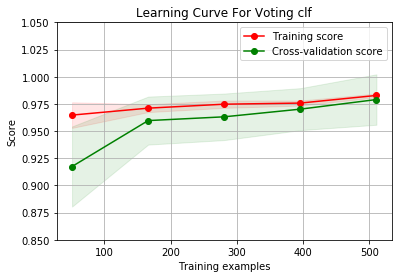

In [48]:
#Learning curve Voting
plot_learning_curve(voting_clf, 'Learning Curve For Voting clf', X, y, (0.85,1.05), 10)
plt.savefig('9')
plt.show()

Recall w/ threshold = 0.1 : 1.0
Recall w/ threshold = 0.2 : 1.0
Recall w/ threshold = 0.3 : 0.9565217391304348
Recall w/ threshold = 0.4 : 0.9565217391304348
Recall w/ threshold = 0.5 : 0.9565217391304348
Recall w/ threshold = 0.6 : 0.9565217391304348
Recall w/ threshold = 0.7 : 0.9130434782608695
Recall w/ threshold = 0.8 : 0.8695652173913043
Recall w/ threshold = 0.9 : 0.782608695652174


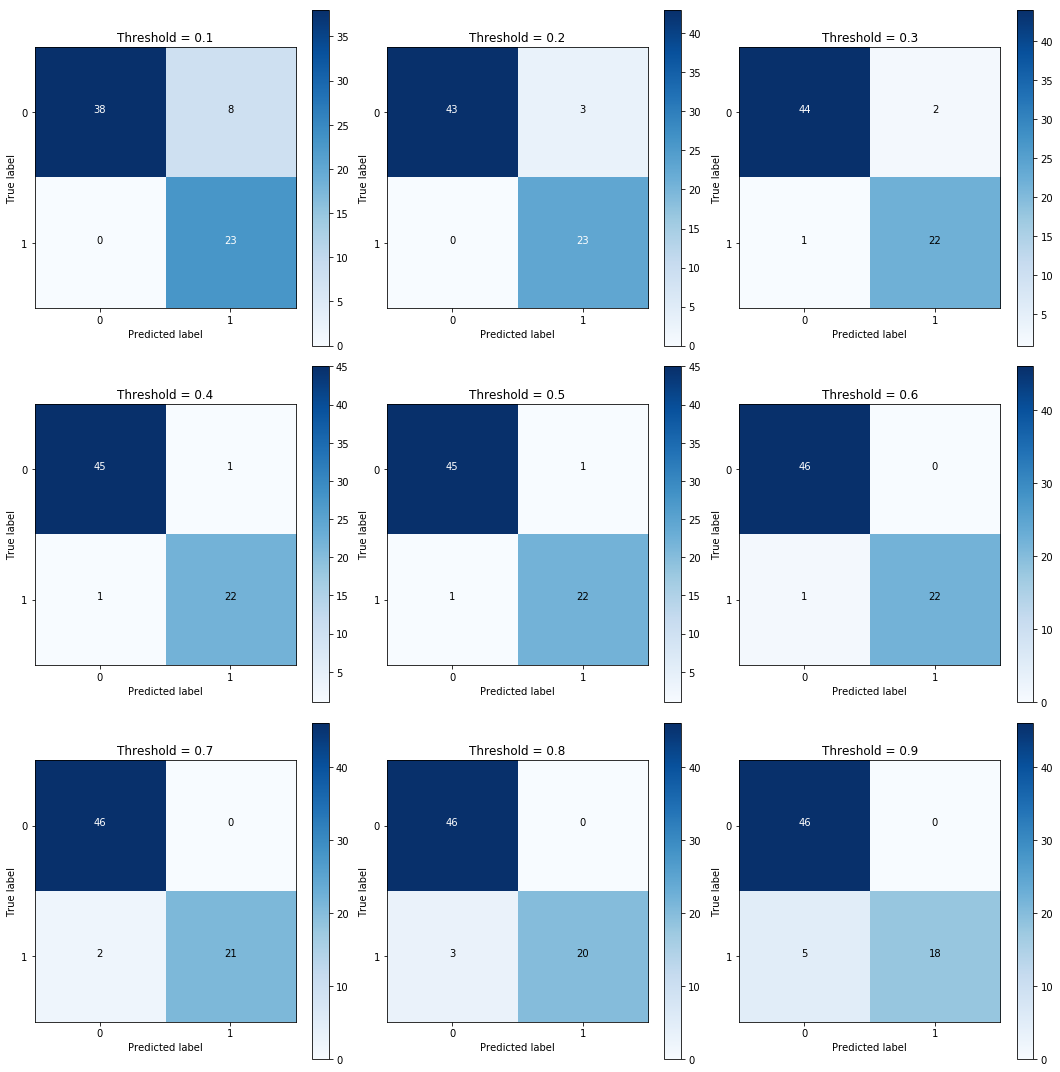

In [49]:
#Voting classifier : select threshold (recall = 100%)
# Threshold

thresholds_adj = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize = (15,15))

j = 1
for i in thresholds_adj:
    y_score = voting_clf.predict_proba(X_test)[:,1] > i
    
    
    plt.subplot(3,3,j)
    j += 1
    
    cm = confusion_matrix(y_test, y_score)
    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]

    print('Recall w/ threshold = %s :'%i, (tp/(tp+fn)))
    
    class_names = [0,1]
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='Threshold = %s'%i) 

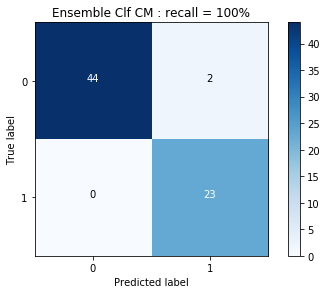

Accuracy  =     0.971
Precision =     0.920
Recall    =     1.000
F1_score  =     0.958


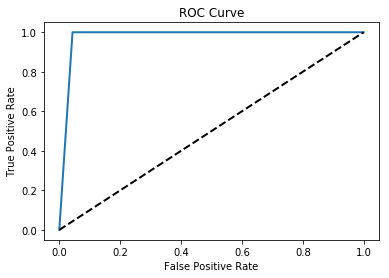

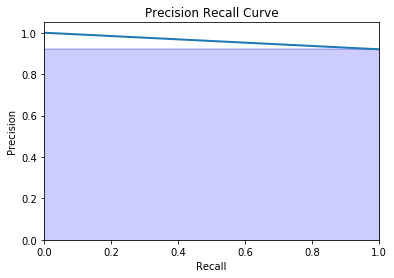

In [50]:
#Voting classifier : predicting with recall = 100% (precision = 92%)
# Ensemble, recall = 1.
y_score = voting_clf.predict_proba(X_test)[:,1] > 0.23
cm = confusion_matrix(y_test, y_score)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'Ensemble Clf CM : recall = 100%')
plt.savefig('8')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

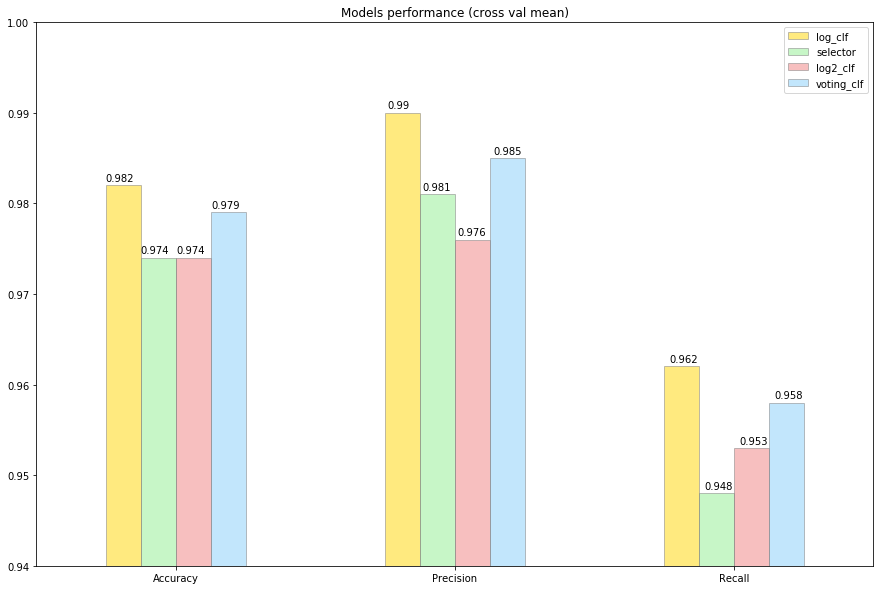

In [51]:
#Models performance plot (accuracy, precision, recall)

models_metrics = {'log_clf': [0.982, 0.990, 0.962], 
                 'selector': [0.974, 0.981, 0.948],
                 'log2_clf' : [0.974,0.976,0.953],
                 'voting_clf' : [0.979,0.985,0.958]
                }
df = pd.DataFrame(data = models_metrics)
df.rename(index={0:'Accuracy',1:'Precision', 2: 'Recall'}, 
                 inplace=True)
ax = df.plot(kind='bar', figsize = (15,10), ylim = (0.94, 1), 
        color = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue'],
        rot = 0, title ='Models performance (cross val mean)',
        edgecolor = 'grey', alpha = 0.5)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.0005))
plt.show()